In [1]:
#https://ieeexplore.ieee.org/document/10549889

In [2]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from ssqueezepy import cwt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-11-29 08:35:19.197503: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 08:35:19.197599: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 08:35:19.197646: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 08:35:19.208368: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import keras.models
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [5]:
# Load datasets
ppg_data_combined = pd.read_excel('combined_dataset.xlsx')

ppg_data_combined['Sex(M/F)'] = ppg_data_combined['Sex(M/F)'].map({'Male': 1, 'Female': 0})

print(ppg_data_combined)

     Num.  subject_ID  Sex(M/F)  Age(year)  Height(cm)  Weight(kg)  \
0       1           2         0         45         152          63   
1       1           2         0         45         152          63   
2       1           2         0         45         152          63   
3       2           3         0         50         157          50   
4       2           3         0         50         157          50   
..    ...         ...       ...        ...         ...         ...   
652   218         418         1         25         173          63   
653   218         418         1         25         173          63   
654   219         419         1         24         175          58   
655   219         419         1         24         175          58   
656   219         419         1         24         175          58   

     Systolic Blood Pressure(mmHg)  Diastolic Blood Pressure(mmHg)  \
0                              161                              89   
1                  

In [6]:
# 참가자의 숫자 확인
print(ppg_data_combined['subject_ID'].nunique())

219


The dataset provided by Liang et al. in their study is a valuable resource for non-invasive CVD detection, encompassing 657 data segments from 219 individuals.

In [7]:
data_systolic = ppg_data_combined["Systolic Blood Pressure(mmHg)"]
data_diastolic = ppg_data_combined["Diastolic Blood Pressure(mmHg)"]
data_sex = ppg_data_combined["Sex(M/F)"]
data_age = ppg_data_combined["Age(year)"]
data_height = ppg_data_combined["Height(cm)"]
data_weight = ppg_data_combined["Weight(kg)"]
data_hr = ppg_data_combined["Heart Rate(b/m)"]
data_bmi = ppg_data_combined["BMI(kg/m^2)"]

ppg_data = ppg_data_combined.iloc[:,14:]

data_personal = pd.concat([data_sex, data_age, data_height, data_weight, data_hr, data_bmi], axis=1)

In [8]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data
scaler.fit(data_personal)

# Transform the data
normalized_data = scaler.transform(data_personal)

In [9]:
# Convert back to a DataFrame (optional, if you need the result as a DataFrame)
normalized_df = pd.DataFrame(normalized_data, columns=data_personal.columns)

ppg_data = np.array(ppg_data)
data_personal = np.array(normalized_df)
print(ppg_data)
print(data_personal)

[[2438 2438 2438 ... 1827 1754 1754]
 [2201 2201 2171 ... 1997 1997 1997]
 [2019 2014 2014 ... 1924 1929 1929]
 ...
 [3083 3039 3071 ... 2422 2451 2379]
 [2426 2431 2446 ... 3103 3146 3151]
 [2691 2718 2743 ... 2611 2639 2623]]
[[0.         0.36923077 0.1372549  0.40298507 0.83333333 0.55232326]
 [0.         0.36923077 0.1372549  0.40298507 0.83333333 0.55232326]
 [0.         0.36923077 0.1372549  0.40298507 0.83333333 0.55232326]
 ...
 [1.         0.04615385 0.58823529 0.32835821 0.24074074 0.18650234]
 [1.         0.04615385 0.58823529 0.32835821 0.24074074 0.18650234]
 [1.         0.04615385 0.58823529 0.32835821 0.24074074 0.18650234]]


In [10]:
# Assuming bp_data has columns 'systolic' and 'diastolic'
# Normalize blood pressure data
bp_data = np.array([data_systolic, data_diastolic]).T
print(bp_data)

[[161  89]
 [161  89]
 [161  89]
 ...
 [108  68]
 [108  68]
 [108  68]]


In [11]:
print(ppg_data.shape)
print(bp_data.shape)

(657, 2100)
(657, 2)


In [12]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(ppg_data, bp_data, test_size=0.2, random_state=42)

print("Train/Test Split:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Train/Test Split:
X_train shape: (525, 2100), y_train shape: (525, 2)
X_test shape: (132, 2100), y_test shape: (132, 2)


In [13]:
# Function to create sliding window data for LSTM
def create_sequence_data(X, y, time_steps=200, step=40):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps - 1])  # Use the last value in the window as the label
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10  # Decrease to allow sliding windows in test set
STEP = 5         # Small step size to maximize number of windows

# Create LSTM-compatible data
X_train_lstm, y_train_lstm = create_sequence_data(X_train, y_train, TIME_STEPS, STEP)
X_test_lstm, y_test_lstm = create_sequence_data(X_test, y_test, TIME_STEPS, STEP)

print("LSTM Data Shapes with Adjusted Parameters:")
print(f"X_train_lstm: {X_train_lstm.shape}, y_train_lstm: {y_train_lstm.shape}")
print(f"X_test_lstm: {X_test_lstm.shape}, y_test_lstm: {y_test_lstm.shape}")

LSTM Data Shapes with Adjusted Parameters:
X_train_lstm: (103, 10, 2100), y_train_lstm: (103, 2)
X_test_lstm: (25, 10, 2100), y_test_lstm: (25, 2)


In [14]:
def CWT_transform(data):
    images = []
    for signal in data:
        Wx, _ = cwt(signal, wavelet='morlet')  # Perform CWT
        Wx = np.abs(Wx)
        Wx = (Wx - Wx.min()) / (Wx.max() - Wx.min())  # Normalize
        images.append(Wx)

    # Ensure all samples have the same shape and convert to numpy array
    images = np.array(images)
    print(f"Shape of transformed data: {images.shape}")
    return images

# Perform CWT transform
X_train_cwt = CWT_transform(X_train)
X_test_cwt = CWT_transform(X_test)

# Add a channel dimension to make the data 3D (height, width, channels)
X_train_cwt = np.array([img[..., np.newaxis] for img in X_train_cwt])  # (246, 2100, 1)
X_test_cwt = np.array([img[..., np.newaxis] for img in X_test_cwt])    # (246, 2100, 1)

# Resize to (128, 128) for CNN input
X_train_cwt = np.array([tf.image.resize(img, [128, 128]).numpy() for img in X_train_cwt])
X_test_cwt = np.array([tf.image.resize(img, [128, 128]).numpy() for img in X_test_cwt])

# Ensure data shape is (samples, 128, 128, 1)
# Do NOT add an extra channel dimension here
print("Final CNN Data Shapes:")
print(f"X_train_cwt: {X_train_cwt.shape}, X_test_cwt: {X_test_cwt.shape}")

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Shape of transformed data: (525, 246, 2100)
Shape of transformed data: (132, 246, 2100)


2024-11-29 08:37:20.033629: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:0b:00.0, compute capability: 8.0
2024-11-29 08:37:20.035963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:4c:00.0, compute capability: 8.0


Final CNN Data Shapes:
X_train_cwt: (525, 128, 128, 1), X_test_cwt: (132, 128, 128, 1)


In [15]:
# Slice CNN data to match LSTM samples
X_train_cwt = X_train_cwt[:X_train_lstm.shape[0]]
X_test_cwt = X_test_cwt[:X_test_lstm.shape[0]]

# Debug final shapes
print("After Slicing:")
print(f"X_train_cwt shape: {X_train_cwt.shape}, X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_lstm shape: {y_train_lstm.shape}")

After Slicing:
X_train_cwt shape: (103, 128, 128, 1), X_train_lstm shape: (103, 10, 2100)
y_train_lstm shape: (103, 2)


In [16]:
# LSTM model for sequence data
def create_lstm_model(input_shape):
    model = Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(32, return_sequences=True),
        layers.Dropout(0.3),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.3),
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.3),
        layers.LSTM(128),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu')
    ])
    return model

In [17]:
# CNN model for CWT images
def create_cnn_model(input_shape):
    model = Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu')
    ])
    return model

In [18]:
# Define input shapes
lstm_input_shape = (TIME_STEPS, X_train.shape[1])  # (200, 2100)
cnn_input_shape = (128, 128, 1)                   # (128, 128, 1)

# Define inputs
lstm_input = layers.Input(shape=lstm_input_shape, name="LSTM_Input")
cnn_input = layers.Input(shape=cnn_input_shape, name="CNN_Input")

# Create submodels
lstm_model = create_lstm_model(lstm_input_shape)(lstm_input)
cnn_model = create_cnn_model(cnn_input_shape)(cnn_input)

# Concatenate outputs
merged = layers.Concatenate()([lstm_model, cnn_model])

# Final output layer for SBP and DBP prediction
output = layers.Dense(2, activation='linear', name="BP_Output")(merged)

# Define the full model
model = Model(inputs=[lstm_input, cnn_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 LSTM_Input (InputLayer)     [(None, 10, 2100)]           0         []                            
                                                                                                  
 CNN_Input (InputLayer)      [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128)                  544768    ['LSTM_Input[0][0]']          
                                                                                                  
 sequential_1 (Sequential)   (None, 128)                  256768    ['CNN_Input[0][0]']           
                                                                                              

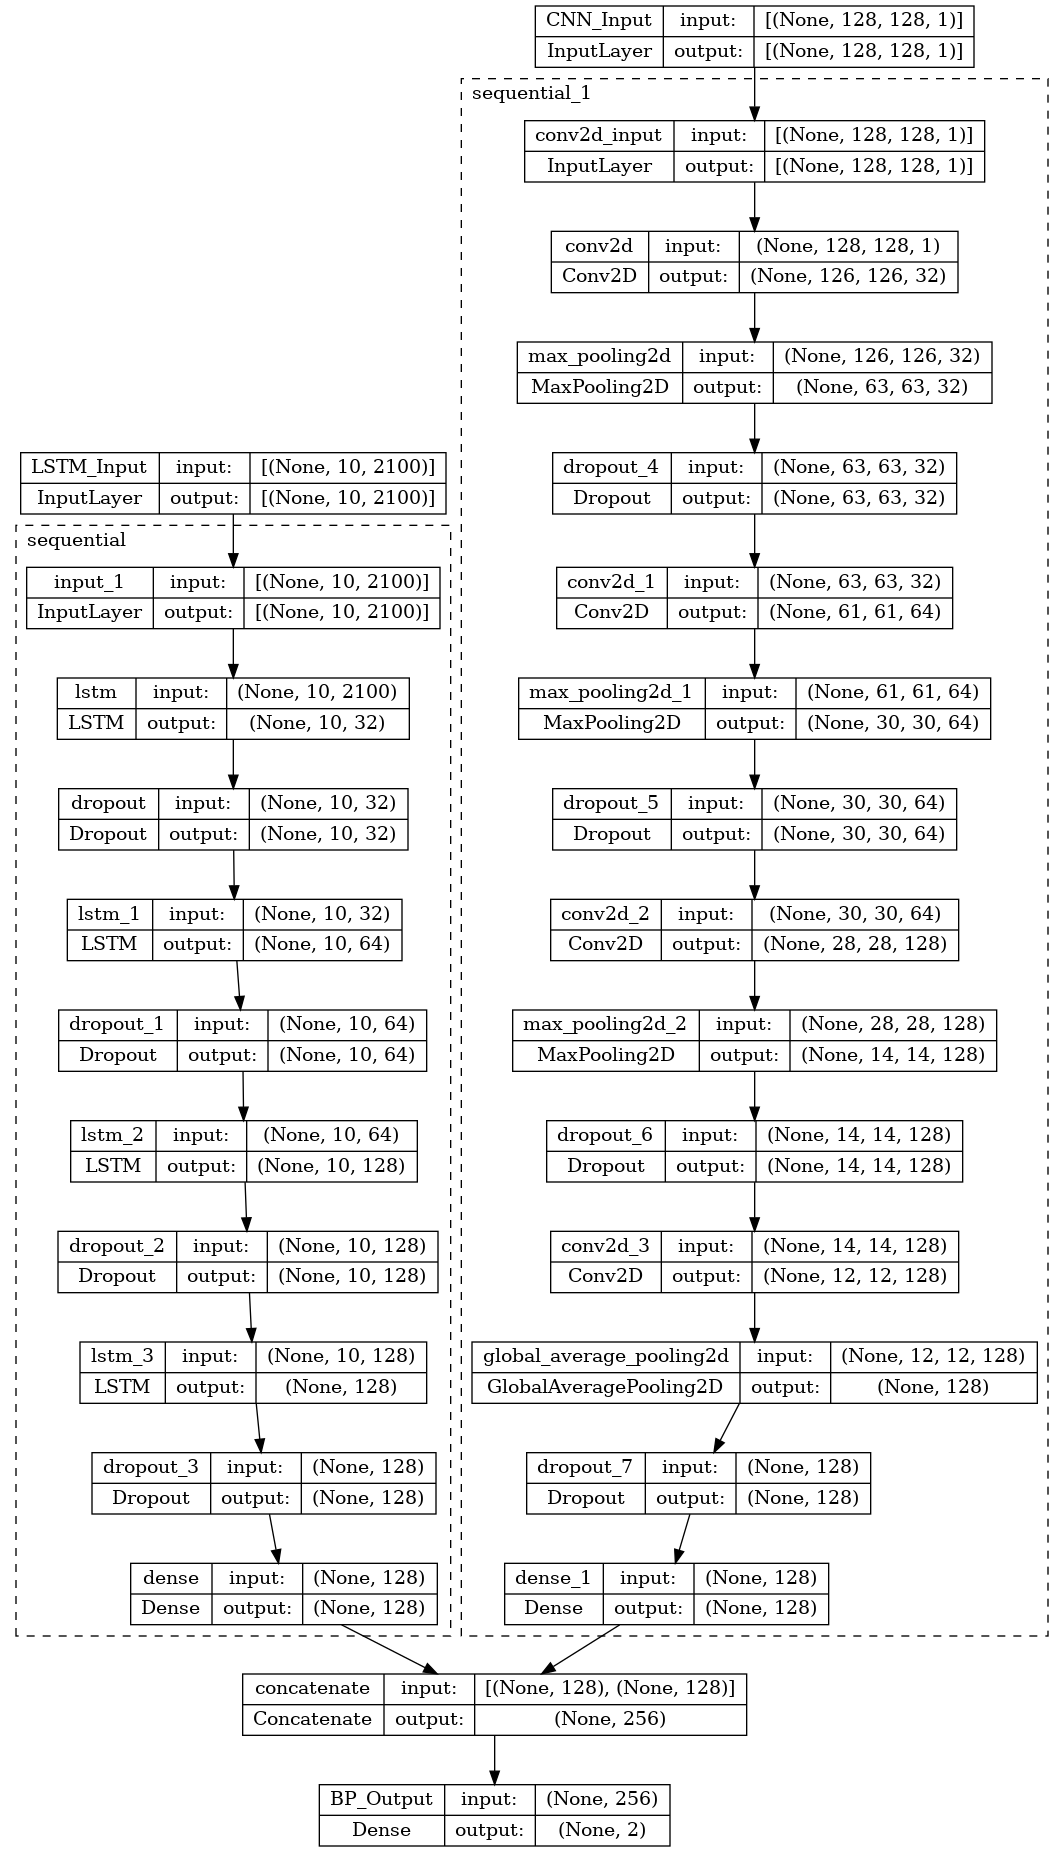

In [19]:
from tensorflow.keras.utils import plot_model

# 모델 시각화
plot_model(
    model,                   # 학습에 사용된 모델
    to_file="model_plot.png",  # 저장할 파일 이름
    show_shapes=True,         # 각 레이어의 출력 텐서 모양 표시
    show_layer_names=True,    # 레이어 이름 표시
    expand_nested=True,       # 중첩된 모델 (서브모델) 시각화
    dpi=96                    # 해상도 설정
)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with updated settings
history = model.fit(
    {"LSTM_Input": X_train_lstm, "CNN_Input": X_train_cwt},
    {"BP_Output": y_train_lstm},
    validation_data=(
        {"LSTM_Input": X_test_lstm, "CNN_Input": X_test_cwt},
        {"BP_Output": y_test_lstm}
    ),
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/500


2024-11-29 08:37:26.811772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1021] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-29 08:37:27.365241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-29 08:37:28.738824: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7689092b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-29 08:37:28.738893: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-11-29 08:37:28.738901: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-11-29 08:37:28.744320: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set 

4/4 [==============================] - 9s 527ms/step - loss: 10870.6953 - mse: 10870.6953 - val_loss: 10046.1934 - val_mse: 10046.1934
Epoch 2/500
4/4 [==============================] - 0s 104ms/step - loss: 10573.2188 - mse: 10573.2188 - val_loss: 9294.2930 - val_mse: 9294.2930
Epoch 3/500
4/4 [==============================] - 0s 74ms/step - loss: 9228.9551 - mse: 9228.9551 - val_loss: 6960.2954 - val_mse: 6960.2954
Epoch 4/500
4/4 [==============================] - 0s 73ms/step - loss: 5499.6143 - mse: 5499.6143 - val_loss: 1843.4736 - val_mse: 1843.4736
Epoch 5/500
4/4 [==============================] - 0s 73ms/step - loss: 1224.7915 - mse: 1224.7915 - val_loss: 1011.7921 - val_mse: 1011.7921
Epoch 6/500
4/4 [==============================] - 0s 45ms/step - loss: 1451.7242 - mse: 1451.7242 - val_loss: 678.1421 - val_mse: 678.1421
Epoch 7/500
4/4 [==============================] - 0s 32ms/step - loss: 729.6534 - mse: 729.6534 - val_loss: 1413.5319 - val_mse: 1413.5319
Epoch 8/500
4/

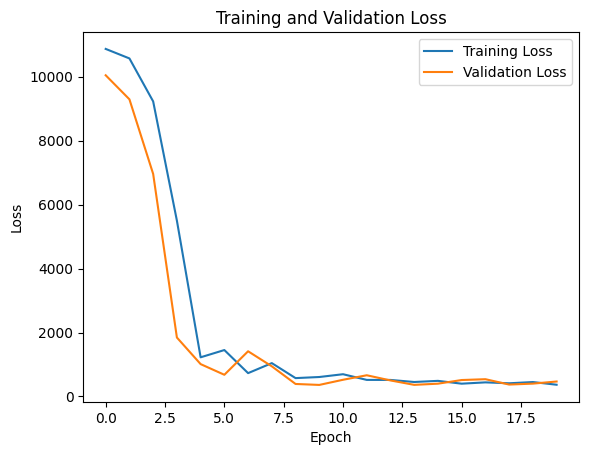

In [21]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [22]:
# Evaluate the model
test_loss, test_mae = model.evaluate(
    {"LSTM_Input": X_test_lstm, "CNN_Input": X_test_cwt},
    {"BP_Output": y_test_lstm}
)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


1/1 [==============================] - 0s 41ms/step - loss: 360.8893 - mse: 360.8893
Test Loss: 360.88934326171875, Test MAE: 360.88934326171875


1/1 [==============================] - 1s 973ms/step


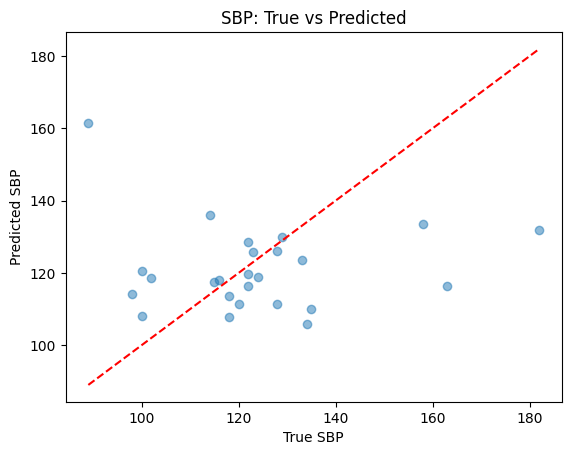

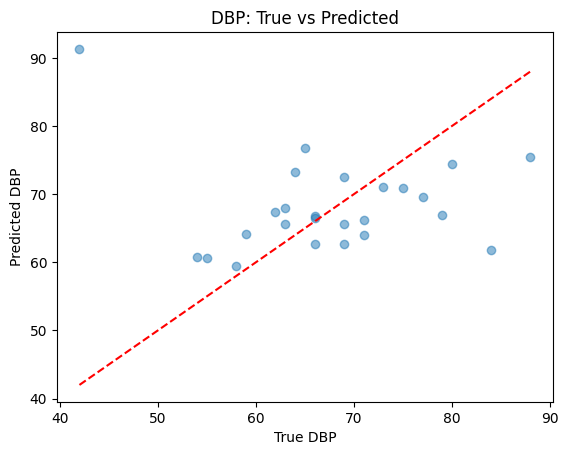

In [23]:
# Predict on test data
predictions = model.predict({"LSTM_Input": X_test_lstm, "CNN_Input": X_test_cwt})

# Compare predictions and true values
predicted_sbp = predictions[:, 0]
predicted_dbp = predictions[:, 1]
true_sbp = y_test_lstm[:, 0]
true_dbp = y_test_lstm[:, 1]

# Scatter plot
plt.scatter(true_sbp, predicted_sbp, alpha=0.5)
plt.plot([min(true_sbp), max(true_sbp)], [min(true_sbp), max(true_sbp)], color='red', linestyle='--')  # Add diagonal
plt.xlabel('True SBP')
plt.ylabel('Predicted SBP')
plt.title('SBP: True vs Predicted')
plt.show()

# Scatter plot for DBP
plt.scatter(true_dbp, predicted_dbp, alpha=0.5)
plt.plot([min(true_dbp), max(true_dbp)], [min(true_dbp), max(true_dbp)], color='red', linestyle='--')  # Add diagonal
plt.xlabel('True DBP')
plt.ylabel('Predicted DBP')
plt.title('DBP: True vs Predicted')
plt.show()



In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate SBP
mae_sbp = mean_absolute_error(true_sbp, predicted_sbp)
mse_sbp = mean_squared_error(true_sbp, predicted_sbp)
print(f"SBP - MAE: {mae_sbp}, MSE: {mse_sbp}")

# Evaluate DBP
mae_dbp = mean_absolute_error(true_dbp, predicted_dbp)
mse_dbp = mean_squared_error(true_dbp, predicted_dbp)
print(f"DBP - MAE: {mae_dbp}, MSE: {mse_dbp}")


SBP - MAE: 16.389937438964843, MSE: 566.6135365207889
DBP - MAE: 7.926299133300781, MSE: 155.16511320719613
